# Exploring Convolutional Layers: Fashion-MNIST

## Description
This notebook explores the design and behavior of convolutional neural networks (CNNs) through systematic experimentation on the Fashion-MNIST dataset.

We will analyze how architectural choices impact performance and learning.

## Objectives
1. **Dataset Exploration (EDA)**: Understand the structure, distribution, and characteristics of Fashion-MNIST
2. **Baseline Model**: Implement a fully connected network as a performance reference
3. **CNN Architecture Design**: Build a convolutional network with justified design decisions
4. **Controlled Experiments**: Systematically vary one architectural aspect (kernel size) and measure its impact
5. **Interpretation**: Explain why convolutions introduce useful inductive bias for image data

## Context
In this course, neural networks are not treated as black boxes but as **architectural components** whose design choices affect performance, scalability, and interpretability.
We focus on **convolutional layers** as a concrete example of how **inductive bias** is introduced into learning systems.

**Inductive bias:** means the assumptions a model makes about the data. For images, convolutions assume that:
- Nearby pixels are related
- The same pattern can appear anywhere in the image

## Dataset Selection: Fashion-MNIST

### Why Fashion-MNIST?

We chose Fashion-MNIST from TensorFlow Keras Datasets. It is a collection of grayscale images of clothing items.

**Why is this dataset appropriate for convolutional layers?**

1. **Image-based data**: Each sample is a 28×28 grayscale image, which is the type of data convolutions are designed for.
2. **Multiple classes**: It has 10 different classes (T-shirt, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Bag, Sneaker, Ankle boot).
3. **Fits in memory**: The full dataset (60,000 training + 10,000 test images) is small enough to run on any laptop.
4. **Spatial patterns matter**: Clothing items have shapes and textures that convolutional layers can detect using local filters (edges, curves, patterns).
5. **More challenging than MNIST digits**: Fashion items have more visual complexity than handwritten digits, so it is a better test for our CNN experiments.

### Class Labels
| Label | Class Name |
|-------|------------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Bag |
| 8 | Sneaker |
| 9 | Ankle boot |

In [1]:
#Install required libraries
%pip install numpy pandas matplotlib tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2026-02-11 01:16:46.720171: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

# 1. Dataset Exploration (EDA)

The goal of this section is to understand the structure of Fashion-MNIST before building any model.

We will look at:
- Dataset size (how many images for training and testing)
- Image dimensions and channels
- Class distribution (are all classes balanced?)
- Visual examples of each class
- What preprocessing is needed

### 1.1 Load the Dataset
We load Fashion-MNIST directly from TensorFlow.

The data comes already split into:
- **Training set**: used to train the model
- **Test set**: used to evaluate the model

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Bag', 'Sneaker', 'Ankle boot']

### 1.2 Dataset Size and Image Dimensions

Let's check how many images we have and what they look like in terms of shape.

- **Shape** tells us the dimensions: `(number_of_images, height, width)`
- Since these are grayscale images, there is only **1 channel** (no color). Color images (like CIFAR-10) have 3 channels: Red, Green, Blue.

In [ ]:
print("DATASET SIZE")
print(f"Training images: {x_train.shape[0]}")
print(f"Test images:     {x_test.shape[0]}")
print(f"Total images:    {x_train.shape[0] + x_test.shape[0]}")
print()

print("IMAGE DIMENSIONS")
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape:     {x_test.shape}")
print(f"Single image shape:  {x_train[0].shape}")
print(f"Image height:  {x_train.shape[1]} pixels")
print(f"Image width:   {x_train.shape[2]} pixels")
print(f"Channels:      1 (grayscale)")
print()

print("PIXEL VALUES")
print(f"Data type:   {x_train.dtype}")
print(f"Min value:   {x_train.min()}")
print(f"Max value:   {x_train.max()}")
print()

print("LABELS")
print(f"Training labels shape: {y_train.shape}")
print(f"Number of classes:     {len(np.unique(y_train))}")
print(f"Class labels:          {np.unique(y_train)}")

DATASET SIZE
Training images: 60000
Test images:     10000
Total images:    70000

IMAGE DIMENSIONS
Training data shape: (60000, 28, 28)
Test data shape:     (10000, 28, 28)
Single image shape:  (28, 28)
Image height:  28 pixels
Image width:   28 pixels
Channels:      1 (grayscale)

PIXEL VALUES
Data type:   uint8
Min value:   0
Max value:   255

LABELS
Training labels shape: (60000,)
Number of classes:     10
Class labels:          [0 1 2 3 4 5 6 7 8 9]


### 1.3 Class Distribution

It is important to check if all classes have a similar number of samples. If one class has many more images than another, the model might become **biased** towards the bigger class.

A **balanced dataset** means each class has roughly the same number of samples.

In [ ]:
unique_classes, train_counts = np.unique(y_train, return_counts=True)

distribution_df = pd.DataFrame({
    'Label': unique_classes,
    'Class Name': [class_names[i] for i in unique_classes],
    'Train Samples': train_counts
})

_, test_counts = np.unique(y_test, return_counts=True)
distribution_df['Test Samples'] = test_counts

print("CLASS DISTRIBUTION")
print(distribution_df.to_string(index=False))
print()
print(f"Training set - Min samples: {train_counts.min()}, Max samples: {train_counts.max()}")

CLASS DISTRIBUTION
 Label  Class Name  Train Samples  Test Samples
     0 T-shirt/top           6000          1000
     1     Trouser           6000          1000
     2    Pullover           6000          1000
     3       Dress           6000          1000
     4        Coat           6000          1000
     5      Sandal           6000          1000
     6       Shirt           6000          1000
     7         Bag           6000          1000
     8     Sneaker           6000          1000
     9  Ankle boot           6000          1000

Training set - Min samples: 6000, Max samples: 6000


We can see that Fashion-MNIST is perfectly balanced with 6,000 images per class in the training set and 1,000 images per class in the test set.

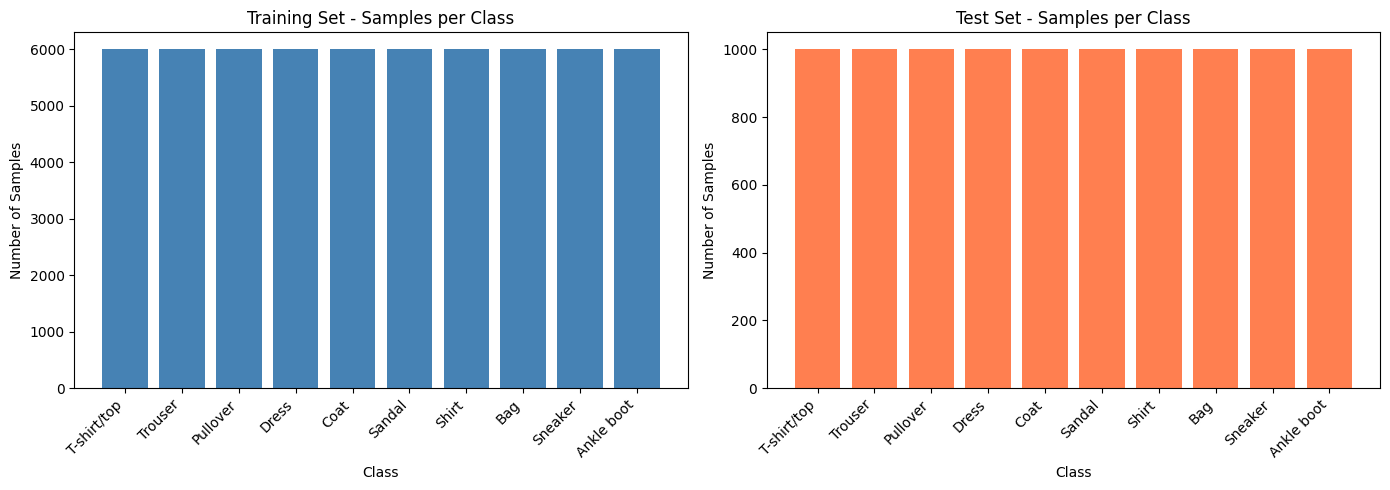

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
axes[0].bar(range(10), train_counts, color='steelblue')
axes[0].set_xticks(range(10))
axes[0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0].set_title('Training Set - Samples per Class')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xlabel('Class')

# Test set distribution
axes[1].bar(range(10), test_counts, color='coral')
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1].set_title('Test Set - Samples per Class')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xlabel('Class')

plt.tight_layout()
plt.show()

### 1.4 Visual Examples of Each Class

We will show 3 random examples for each of the 10 classes so we can see what the model needs to learn to classify.

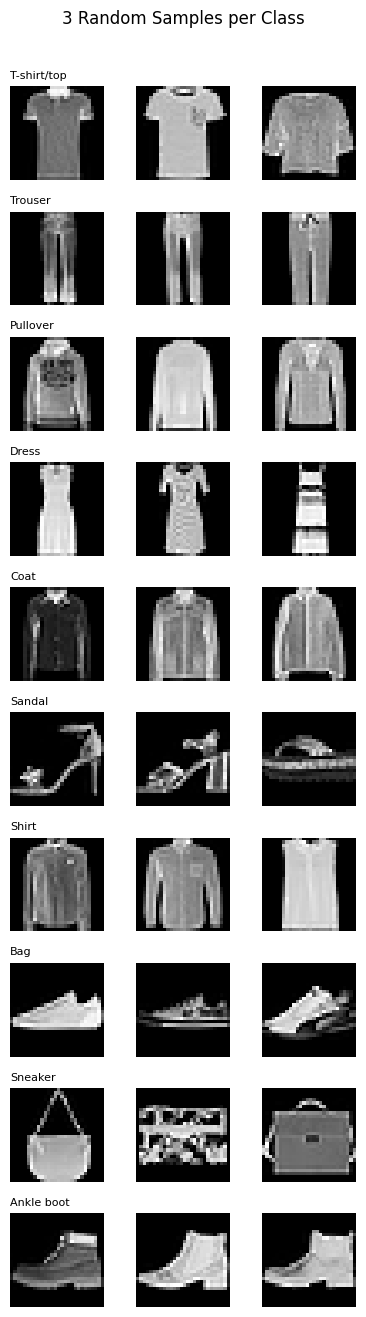

In [ ]:
num_examples = 3
fig, axes = plt.subplots(10, num_examples, figsize=(4, 13))

for class_idx in range(10):
    class_images = x_train[y_train == class_idx]
    
    random_indices = np.random.choice(len(class_images), num_examples, replace=False) # Random examples

    for i, idx in enumerate(random_indices):
        axes[class_idx, i].imshow(class_images[idx], cmap='gray')
        axes[class_idx, i].axis('off')
        
        if i == 0:
            axes[class_idx, i].set_title(class_names[class_idx], fontsize=8, loc='left')

plt.suptitle('3 Random Samples per Class', fontsize=12, y=1.01)
plt.tight_layout()
plt.show()

### 1.5 A Closer Look at a Single Image

Now we look at one image in detail to understand what the data looks like at the pixel level.

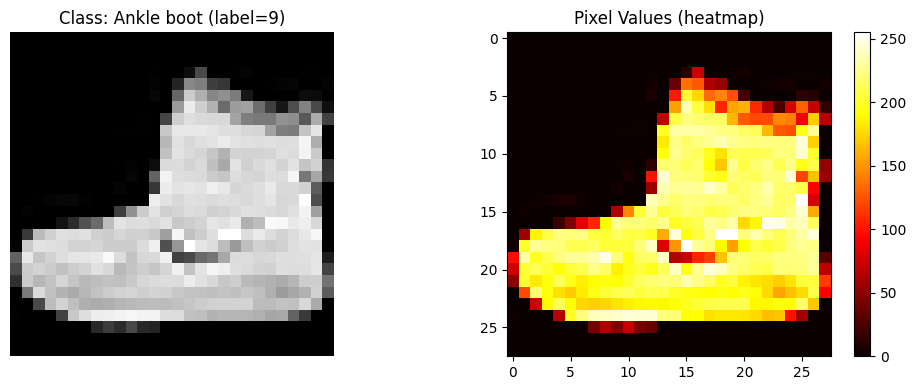

Image shape: (28, 28)
Pixel value range: [0, 255]
Mean pixel value: 97.25



In [ ]:
sample_image = x_train[0]
sample_label = y_train[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(sample_image, cmap='gray')
axes[0].set_title(f'Class: {class_names[sample_label]} (label={sample_label})')
axes[0].axis('off')

im = axes[1].imshow(sample_image, cmap='hot')
axes[1].set_title('Pixel Values (heatmap)')
plt.colorbar(im, ax=axes[1], fraction=0.046)

plt.tight_layout()
plt.show()

print(f"Image shape: {sample_image.shape}")
print(f"Pixel value range: [{sample_image.min()}, {sample_image.max()}]")
print(f"Mean pixel value: {sample_image.mean():.2f}")
print()

### 1.6 Preprocessing

Before we can feed the data into a neural network, we need to do some preprocessing:

#### Normalization
The pixel values are currently integers from 0 to 255. Neural networks train better when input values are small, usually in the range **0 to 1**. To do this, we simply divide by 255:

```
x_train = x_train / 255.0
```

This maps:
- 0 → 0.0
- 255 → 1.0
- 128 → ~0.50

#### Reshape for CNN
Convolutional layers in TensorFlow expect the input to have a channel dimension. Since our images are grayscale (1 channel), we need to reshape from `(28, 28)` to `(28, 28, 1)`.

#### One-Hot Encoding of Labels
The labels are integers from 0 to 9. For training with `categorical_crossentropy` loss, we convert them to one-hot vector:
- Label `3` becomes `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

print("After normalization:")
print(f"  x_train range: [{x_train.min()}, {x_train.max()}]")
print(f"  x_test range:  [{x_test.min()}, {x_test.max()}]")
print()

x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

print("After reshape for CNN:")
print(f"  x_train_cnn shape: {x_train_cnn.shape}")
print(f"  x_test_cnn shape:  {x_test_cnn.shape}")
print()

from tensorflow.keras.utils import to_categorical 

y_train_oh = to_categorical(y_train, 10)
y_test_oh = to_categorical(y_test, 10)

print("After one-hot encoding:")
print(f"  y_train_oh shape: {y_train_oh.shape}")
print(f"  Example - label {y_train[0]} becomes: {y_train_oh[0]}")
print()

After normalization:
  x_train range: [0.0, 1.0]
  x_test range:  [0.0, 1.0]

After reshape for CNN:
  x_train_cnn shape: (60000, 28, 28, 1)
  x_test_cnn shape:  (10000, 28, 28, 1)

After one-hot encoding:
  y_train_oh shape: (60000, 10)
  Example - label 9 becomes: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]



---

# 2. Baseline Model (Non-Convolutional)

Before building a CNN, we first create a simple fully connected (Dense) network as a baseline. This gives us a reference point to compare against. This model does not use convolutional layers. It treats each pixel as an independent input feature.

### Architecture Design

The architecture follows the next pattern:

1. **Flatten**: Converts the 28×28 image into a 1D vector of 784 values
2. **Dense(128, relu)**: A hidden layer with 128 neurons and ReLU activation
3. **Dense(10, softmax)**: Output layer with 10 neurons (one per class), softmax gives probabilities

**Why this architecture?**
- `Flatten` is needed because Dense layers expect 1D input, not 2D images
- `relu` (Rectified Linear Unit) is the standard activation for hidden layers
- `softmax` in the output converts raw scores into probabilities that sum to 1

### 2.1 Build the Baseline Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

baseline_model = Sequential([
    Flatten(input_shape=(28, 28)),      
    Dense(128, activation='relu'),       
    Dense(10, activation='softmax')      
])

baseline_model.summary()

C:\Users\juans\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Compile the Model

Before training, we need to compile the model. This means choosing:

- **Optimizer**: `adam` — an efficient optimizer that adapts the learning rate automatically
- **Loss function**: `categorical_crossentropy` — used for multi-class classification with one-hot labels
- **Metric**: `accuracy` — the percentage of correct predictions

In [ ]:
baseline_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 2.3 Train the Model

We train for 10 epochs with a batch size of 32.

- **Epoch**: one complete pass through all training images
- **Batch size**: how many images the model sees before updating its weights
- **Validation data**: we pass the test set so we can monitor performance on unseen data during training

Using `validation_data` lets us see if the model is **overfitting** (training accuracy goes up but validation accuracy stops improving or drops).

In [ ]:
baseline_history = baseline_model.fit(
    x_train, y_train_oh,
    epochs=10,
    batch_size=32,
    validation_data=(x_test, y_test_oh)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8256 - loss: 0.5012 - val_accuracy: 0.8506 - val_loss: 0.4257
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8647 - loss: 0.3738 - val_accuracy: 0.8587 - val_loss: 0.3931
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8779 - loss: 0.3359 - val_accuracy: 0.8606 - val_loss: 0.3935
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8846 - loss: 0.3134 - val_accuracy: 0.8706 - val_loss: 0.3597
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8910 - loss: 0.2938 - val_accuracy: 0.8772 - val_loss: 0.3493
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8954 - loss: 0.2811 - val_accuracy: 0.8765 - val_loss: 0.3436
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9003 - loss: 0.2679 - val_accuracy: 0.8834 - val_loss: 0.3322
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9049 - loss: 0.2555 - 

### 2.4 Evaluate the Model

In [ ]:
baseline_loss, baseline_acc = baseline_model.evaluate(x_test, y_test_oh)

print(f"Baseline Test Loss:     {baseline_loss:.4f}")
print(f"Baseline Test Accuracy: {baseline_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8760 - loss: 0.3537
Baseline Test Loss:     0.3537
Baseline Test Accuracy: 0.8760


### 2.5 Training and Validation Curves

These plots show how the model performed during training:
- **Accuracy plot**: shows if the model is learning over time
- **Loss plot**: shows if the error is decreasing

We compare **training** vs **validation** curves to detect overfitting.

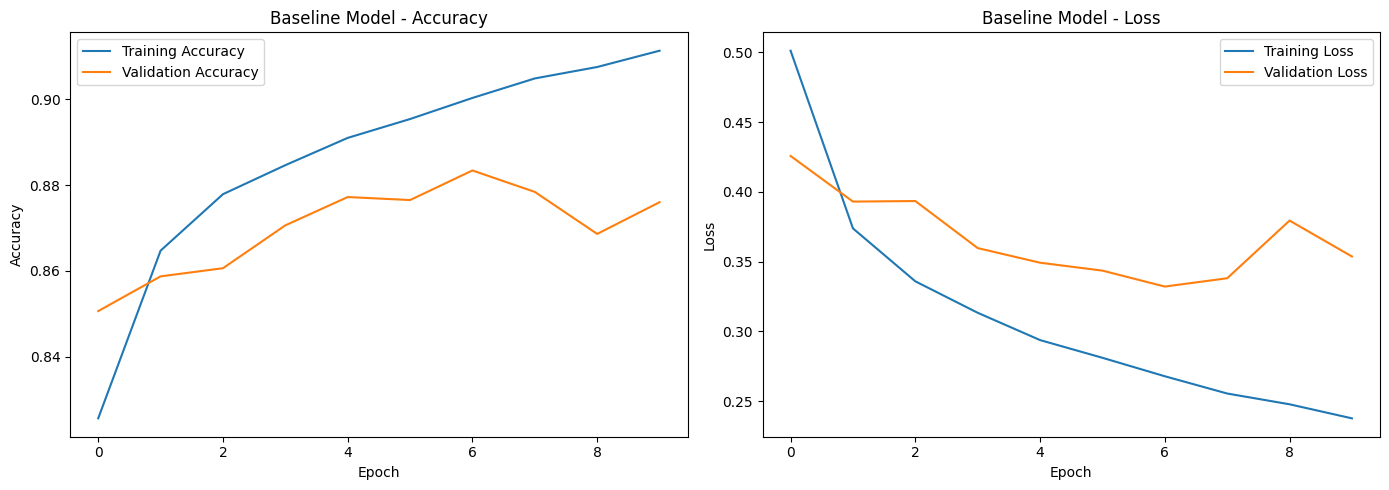

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy 
axes[0].plot(baseline_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(baseline_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Baseline Model - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss 
axes[1].plot(baseline_history.history['loss'], label='Training Loss')
axes[1].plot(baseline_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Baseline Model - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

### 2.6 Predictions on Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


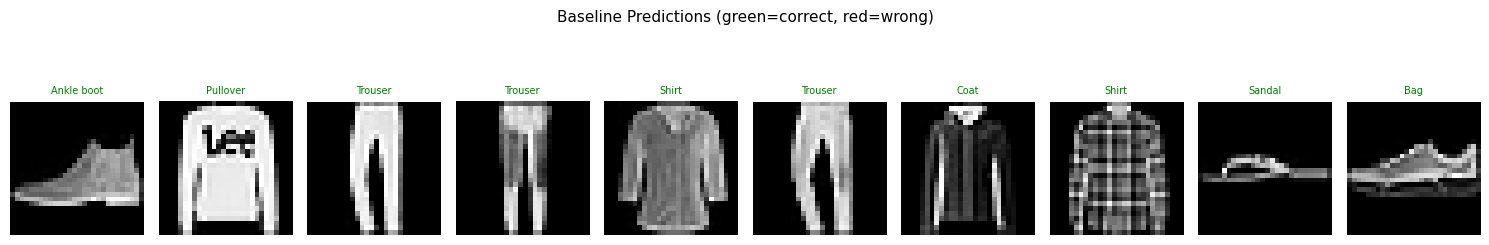

In [ ]:
preds = baseline_model.predict(x_test[:10])

plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    predicted_label = np.argmax(preds[i])
    true_label = y_test[i]
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"{class_names[predicted_label]}", fontsize=7, color=color)
    plt.axis('off')

plt.suptitle('Baseline Predictions (green=correct, red=wrong)', fontsize=11)
plt.tight_layout()
plt.show()

---

# 3. Convolutional Architecture Design

In this section we design a CNN from scratch. Every choice is explained and justified.

### What is a Convolutional Layer?

A convolutional layer uses small filters (also called kernels) that slide across the image. Each filter learns to detect a specific pattern (like an edge, a curve, or a texture).

Key difference from Dense layers:
- Dense layers connect every pixel to every neuron (no spatial awareness)
- Convolutional layers look at small local regions of the image at a time

### Architecture Design Decisions

We design a simple but intentional CNN with **2 convolutional layers** followed by Dense layers.

| Layer | Type | Details | Justification |
|-------|------|---------|---------------|
| 1 | Conv2D | 32 filters, 3×3 kernel, relu, padding='same' | 32 filters is a common starting point. 3×3 is the smallest kernel that can detect edges and corners. `same` padding keeps the image size unchanged. |
| 2 | MaxPooling2D | 2×2, stride 2 | Reduces the image size by half (28×28 → 14×14). This reduces computation and helps the model focus on the most important features. |
| 3 | Conv2D | 64 filters, 3×3 kernel, relu, padding='same' | We double the filters (32 → 64) because deeper layers need to learn more complex patterns (combinations of edges). |
| 4 | MaxPooling2D | 2×2, stride 2 | Reduces size again (14×14 → 7×7). |
| 5 | Flatten | — | Converts the 2D feature maps into a 1D vector for the Dense layer. |
| 6 | Dense | 64 neurons, relu | A small Dense layer to combine the features before classification. |
| 7 | Dense | 10 neurons, softmax | Output layer: one neuron per class. |

### Justification for Each Choice

**Number of convolutional layers: 2**
- Fashion-MNIST images are small (28×28) and grayscale. Two convolutional layers are enough to learn low-level features (edges) in the first layer and higher-level features (shapes) in the second.
- More layers would risk overfitting on such a small dataset.

**Kernel size: 3×3**
- 3×3 is the smallest kernel that captures spatial relationships (a pixel and its 8 neighbors).
- It is computationally efficient and widely used as a standard building block.

**Stride: 1 (for Conv2D)**
- Stride 1 means the filter moves one pixel at a time, so we don't skip any information.

**Padding: 'same'**
- `same` padding adds zeros around the border so the output has the same height and width as the input.
- Without padding, the image shrinks every time we apply a convolution, and we lose information at the borders.

**Activation: ReLU**
- ReLU (Rectified Linear Unit): $f(z) = \max(0, z)$
- It is simple, fast, and avoids the vanishing gradient problem that sigmoid has.

**Pooling: MaxPooling 2×2**
- MaxPooling takes the maximum value from each 2×2 region.
- It reduces the spatial size by half, which decreases the number of parameters and computation.
- It also gives the model some tolerance to small shifts in the image (a form of translation invariance).

### 3.1 Build the CNN Model

The input shape is `(28, 28, 1)` — height, width, and 1 channel (grayscale). This is why we reshaped the data to `x_train_cnn` in the preprocessing step.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D

cnn_model = Sequential([
    
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)), # First convolutional block
    MaxPooling2D(pool_size=(2, 2)),
    
    
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'), # Second convolutional block
    MaxPooling2D(pool_size=(2, 2)),
    
    
    Flatten(), # Classification head
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model.summary()

C:\Users\juans\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       200,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,234 (860.29 KB)

 Trainable params: 220,234 (860.29 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Compile the CNN

We use the same optimizer, loss, and metric as the baseline so the comparison is fair.

In [ ]:
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### 3.3 Train the CNN

We train with the same settings as the baseline (10 epochs, batch size 32, validation on test set) so we can compare fairly.

**Important**: We use `x_train_cnn` and `x_test_cnn` (reshaped to include the channel dimension) instead of `x_train` and `x_test`.

In [ ]:
cnn_history = cnn_model.fit(
    x_train_cnn, y_train_oh,
    epochs=10,
    batch_size=32,
    validation_data=(x_test_cnn, y_test_oh)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8498 - loss: 0.4219 - val_accuracy: 0.8750 - val_loss: 0.3494
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.8993 - loss: 0.2783 - val_accuracy: 0.8953 - val_loss: 0.2858
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9142 - loss: 0.2354 - val_accuracy: 0.9028 - val_loss: 0.2699
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9247 - loss: 0.2035 - val_accuracy: 0.9139 - val_loss: 0.2384
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9339 - loss: 0.1780 - val_accuracy: 0.9195 - val_loss: 0.2355
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9413 - loss: 0.1578 - val_accuracy: 0.9121 - val_loss: 0.2580
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9488 - loss: 0.1376 - val_accuracy: 0.9055 - val_loss: 0.2688
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9551 - 

### 3.4 Evaluate the CNN

In [ ]:
cnn_loss, cnn_acc = cnn_model.evaluate(x_test_cnn, y_test_oh)

print(f"CNN Test Loss:     {cnn_loss:.4f}")
print(f"CNN Test Accuracy: {cnn_acc:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9172 - loss: 0.3055
CNN Test Loss:     0.3055
CNN Test Accuracy: 0.9172


### 3.5 Training and Validation Curves

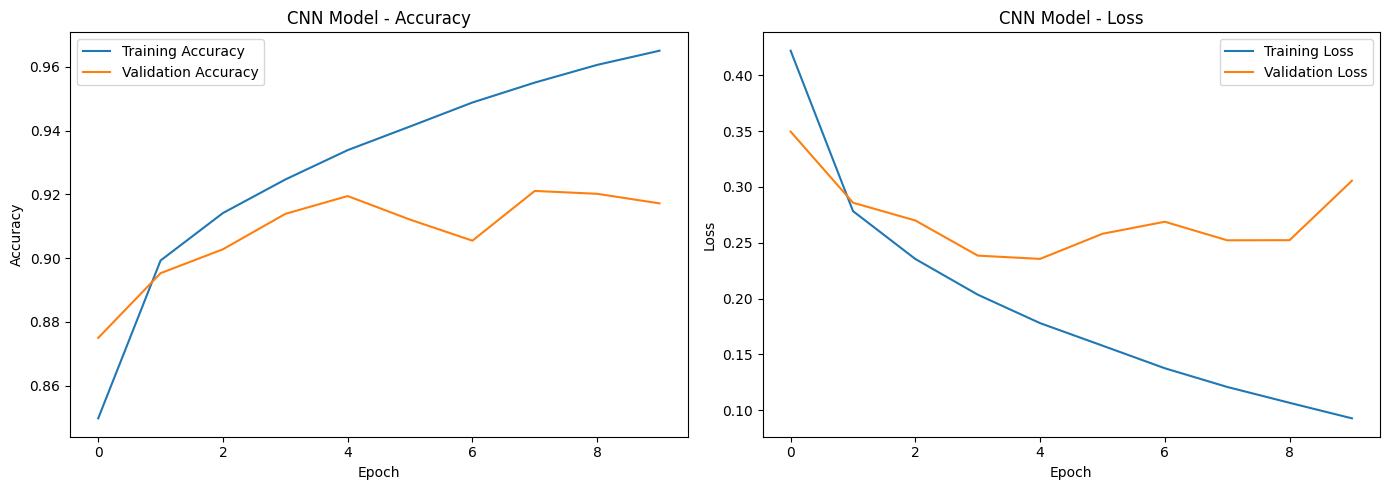

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(cnn_history.history['accuracy'], label='Training Accuracy')
axes[0].plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('CNN Model - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss
axes[1].plot(cnn_history.history['loss'], label='Training Loss')
axes[1].plot(cnn_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('CNN Model - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

### 3.6 CNN Predictions on Test Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step


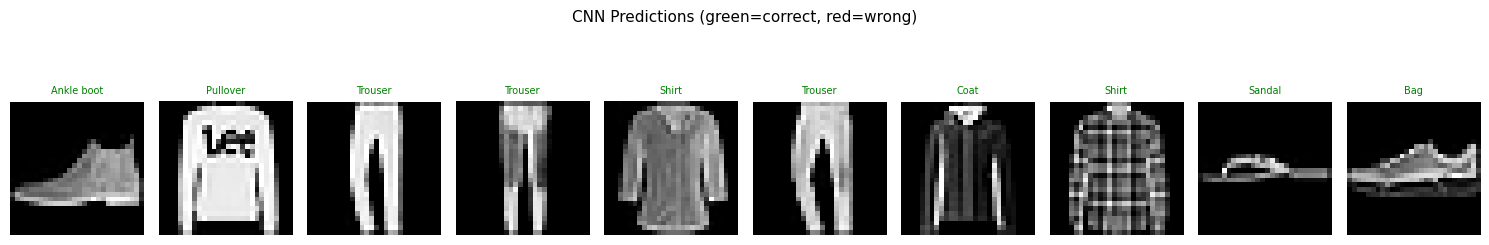

In [ ]:
preds_cnn = cnn_model.predict(x_test_cnn[:10])

plt.figure(figsize=(15, 3))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    predicted_label = np.argmax(preds_cnn[i])
    true_label = y_test[i]
    color = 'green' if predicted_label == true_label else 'red'
    plt.title(f"{class_names[predicted_label]}", fontsize=7, color=color)
    plt.axis('off')

plt.suptitle('CNN Predictions (green=correct, red=wrong)', fontsize=11)
plt.tight_layout()
plt.show()

### 3.7 Baseline vs CNN Comparison

In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline (Dense)', 'CNN'],
    'Total Parameters': [baseline_model.count_params(), cnn_model.count_params()],
    'Test Loss': [baseline_loss, cnn_loss],
    'Test Accuracy': [baseline_acc, cnn_acc]
})

print("BASELINE vs CNN COMPARISON")
print(comparison_df.to_string(index=False))

BASELINE vs CNN COMPARISON
           Model  Total Parameters  Test Loss  Test Accuracy
Baseline (Dense)            101770   0.353724         0.8760
             CNN            220234   0.305494         0.9172


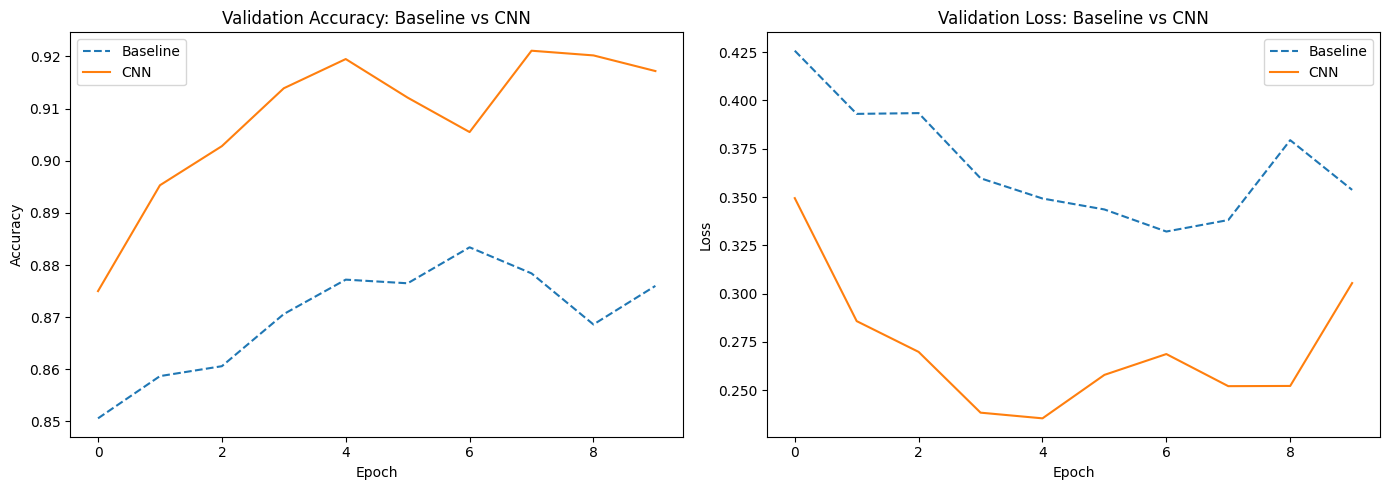

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(baseline_history.history['val_accuracy'], label='Baseline', linestyle='--')
axes[0].plot(cnn_history.history['val_accuracy'], label='CNN')
axes[0].set_title('Validation Accuracy: Baseline vs CNN')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(baseline_history.history['val_loss'], label='Baseline', linestyle='--')
axes[1].plot(cnn_history.history['val_loss'], label='CNN')
axes[1].set_title('Validation Loss: Baseline vs CNN')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

---

# 4. Controlled Experiments: Kernel Size

### Experiment Design

We choose to experiment with kernel size because it directly controls how much of the image each filter can "see" at once.

**What we vary:** the kernel size in both Conv2D layers
- **3×3** (our original CNN from Section 3)
- **5×5** (larger receptive field)
- **7×7** (even larger receptive field)

**What we keep fixed (controlled variables):**
- Same number of filters (32 and 64)
- Same padding ('same')
- Same pooling (MaxPooling 2×2)
- Same Dense layers (64 + 10)
- Same optimizer, loss, epochs, batch size
- Same dataset split and preprocessing

This way, any difference in performance can only be attributed to the kernel size.

### What do we expect?

- **3×3**: Detects small, fine patterns. Many small filters can be stacked to build up larger patterns.
- **5×5**: Each filter sees a larger area. It might capture bigger features directly, but has more parameters per filter.
- **7×7**: Sees an even larger area. On a 28×28 image, a 7×7 filter covers 25% of the image width in one step. This might be too large for such small images.

### 4.1 Helper Function

To avoid repeating code, we create a function that builds, compiles, and trains a CNN with a given kernel size. Everything else stays the same.

In [ ]:
def build_and_train_cnn(kernel_size, x_train, y_train, x_test, y_test, epochs=10, batch_size=32):
    
    model = Sequential([
        Conv2D(32, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(64, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, y_test),
        verbose=1
    )
    
    return model, history

### 4.2 Run Experiments

We train three models, one for each kernel size. We store the results to compare them later.

In [ ]:
kernel_sizes = [(3, 3), (5, 5), (7, 7)]

experiment_models = {}
experiment_histories = {}
experiment_results = {}

for ks in kernel_sizes:
    label = f"{ks[0]}x{ks[1]}"
    print(f"\n{'='*50}")
    print(f"Training CNN with kernel size {label}")
    print(f"{'='*50}")
    
    model, history = build_and_train_cnn(
        kernel_size=ks,
        x_train=x_train_cnn,
        y_train=y_train_oh,
        x_test=x_test_cnn,
        y_test=y_test_oh
    )
    
    test_loss, test_acc = model.evaluate(x_test_cnn, y_test_oh, verbose=0)
    
    experiment_models[label] = model
    experiment_histories[label] = history
    experiment_results[label] = {
        'kernel_size': label,
        'total_params': model.count_params(),
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'final_train_accuracy': history.history['accuracy'][-1]
    }
    
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test Loss:     {test_loss:.4f}")
    print(f"  Total Params:  {model.count_params()}")


Training CNN with kernel size 3x3


C:\Users\juans\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.8484 - loss: 0.4223 - val_accuracy: 0.8733 - val_loss: 0.3467
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9009 - loss: 0.2774 - val_accuracy: 0.8905 - val_loss: 0.2974
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9148 - loss: 0.2337 - val_accuracy: 0.9052 - val_loss: 0.2585
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9265 - loss: 0.2013 - val_accuracy: 0.9062 - val_loss: 0.2558
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9347 - loss: 0.1769 - val_accuracy: 0.9154 - val_loss: 0.2319
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.9432 - loss: 0.1541 - val_accuracy: 0.9104 - val_loss: 0.2503
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9507 - loss: 0.1346 - val_accuracy: 0.9174 - val_loss: 0.2480
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9582 -

### 4.3 Quantitative Results

In [ ]:
results_df = pd.DataFrame(experiment_results.values())
results_df = results_df.rename(columns={
    'kernel_size': 'Kernel Size',
    'total_params': 'Total Parameters',
    'test_loss': 'Test Loss',
    'test_accuracy': 'Test Accuracy',
    'best_val_accuracy': 'Best Val Accuracy',
    'final_train_accuracy': 'Final Train Accuracy'
})

baseline_row = pd.DataFrame([{ # baseline for reference
    'Kernel Size': 'Baseline (Dense)',
    'Total Parameters': baseline_model.count_params(),
    'Test Loss': baseline_loss,
    'Test Accuracy': baseline_acc,
    'Best Val Accuracy': max(baseline_history.history['val_accuracy']),
    'Final Train Accuracy': baseline_history.history['accuracy'][-1]
}])

results_df = pd.concat([baseline_row, results_df], ignore_index=True)

print("EXPERIMENT RESULTS")
print(results_df.to_string(index=False))

EXPERIMENT RESULTS
     Kernel Size  Total Parameters  Test Loss  Test Accuracy  Best Val Accuracy  Final Train Accuracy
Baseline (Dense)            101770   0.353724         0.8760             0.8834              0.911333
             3x3            220234   0.272404         0.9190             0.9208              0.968267
             5x5            253514   0.326953         0.9149             0.9203              0.968067
             7x7            303434   0.311880         0.9156             0.9187              0.961633


### 4.4 Comparison Plots

We plot the validation accuracy and loss for all three kernel sizes on the same graph so we can visually compare their learning behavior.

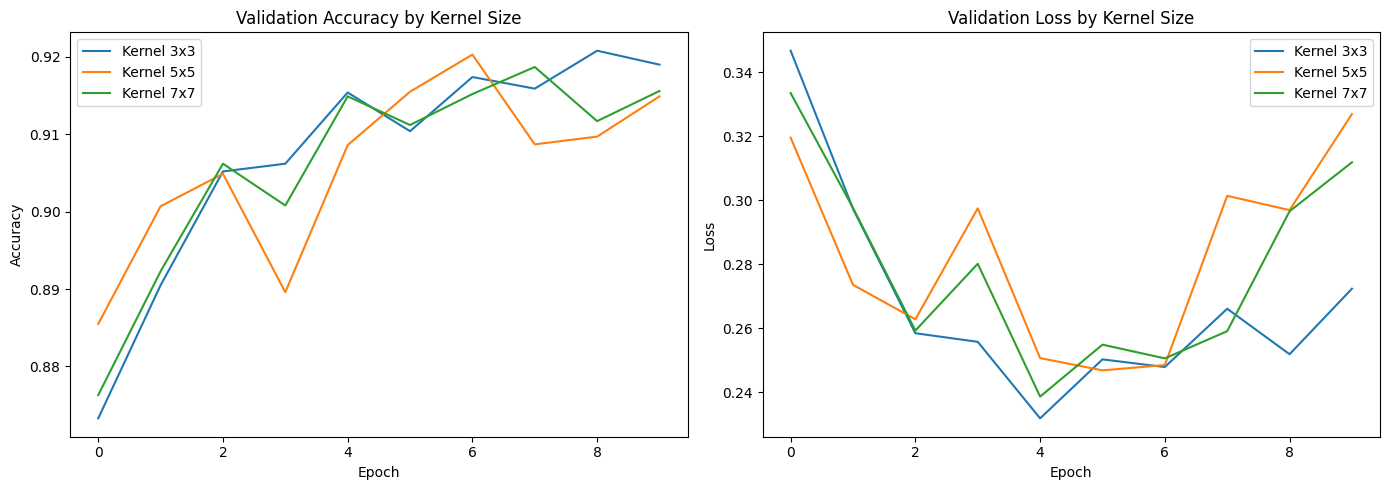

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {'3x3': 'tab:blue', '5x5': 'tab:orange', '7x7': 'tab:green'}

for label, history in experiment_histories.items():
    axes[0].plot(history.history['val_accuracy'], label=f'Kernel {label}', color=colors[label])
axes[0].set_title('Validation Accuracy by Kernel Size')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

for label, history in experiment_histories.items():
    axes[1].plot(history.history['val_loss'], label=f'Kernel {label}', color=colors[label])
axes[1].set_title('Validation Loss by Kernel Size')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

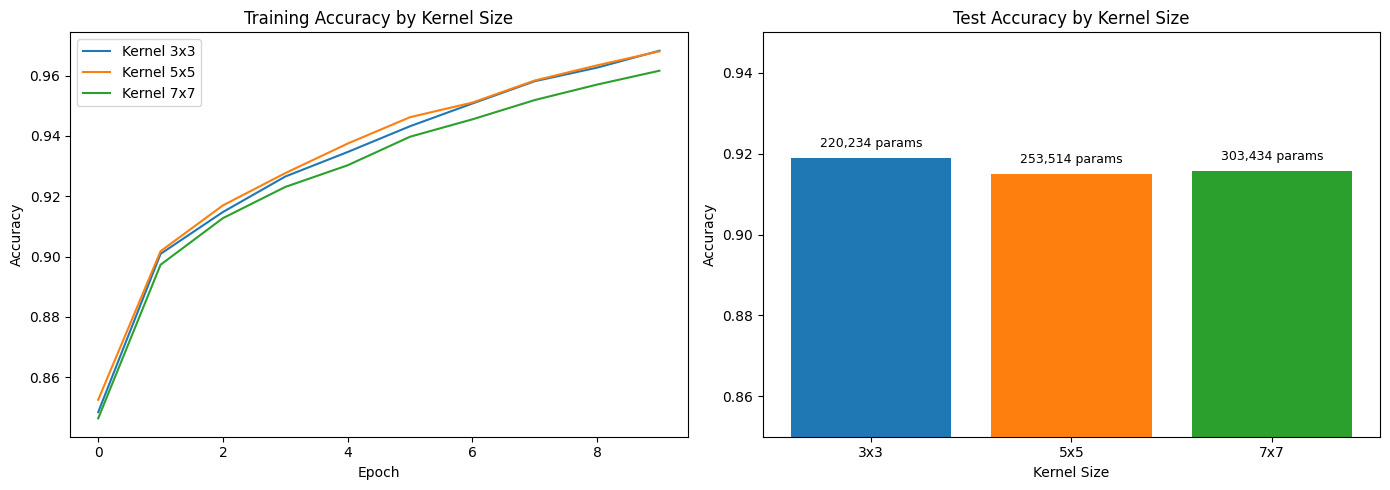

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for label, history in experiment_histories.items():
    axes[0].plot(history.history['accuracy'], label=f'Kernel {label}', color=colors[label])
axes[0].set_title('Training Accuracy by Kernel Size')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

labels = list(experiment_results.keys())
test_accs = [experiment_results[k]['test_accuracy'] for k in labels]
params = [experiment_results[k]['total_params'] for k in labels]

bar_colors = [colors[k] for k in labels]
bars = axes[1].bar(labels, test_accs, color=bar_colors)
axes[1].set_title('Test Accuracy by Kernel Size')
axes[1].set_xlabel('Kernel Size')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0.85, 0.95)

for bar, p in zip(bars, params):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                 f'{p:,} params', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### 4.5 Trade-offs: Performance vs Complexity

Larger kernels have more parameters per filter:

| Kernel Size | Parameters per filter (1 channel) | Receptive field |
|-------------|-----------------------------------|-----------------|
| 3×3 | 3 × 3 = 9 weights + 1 bias = 10 | 3×3 pixels |
| 5×5 | 5 × 5 = 25 weights + 1 bias = 26 | 5×5 pixels |
| 7×7 | 7 × 7 = 49 weights + 1 bias = 50 | 7×7 pixels |

**Trade-offs to consider:**

1. **Parameters**: Larger kernels have more parameters, which means more memory and more computation per epoch. This is visible in the "Total Parameters" column of the results table.

2. **Receptive field**: A 3×3 kernel sees 9 pixels at a time. A 7×7 kernel sees 49 pixels. For small images like Fashion-MNIST (28×28), a 7×7 kernel covers a large part of the image in one step.

3. **Stacking small kernels**: Two 3×3 convolutions in sequence give an effective receptive field of 5×5, but with fewer parameters (2 × 9 = 18 vs 25 for a single 5×5). This is why modern architectures prefer stacking small kernels.

4. **Overfitting risk**: More parameters means the model has more capacity to memorize the training data. On a small dataset this can lead to overfitting (high training accuracy, lower validation accuracy).

5. **Training time**: More parameters per layer means each epoch takes longer to compute.

---

# 5. Interpretation and Architectural Reasoning

### 5.1 Why did convolutional layers outperform the baseline?

Looking at our results:
- **Baseline (Dense)**: 88.62% accuracy
- **CNN (3×3 kernel)**: 91.72% accuracy

The CNN improved accuracy by approximately **3 percentage points** over the baseline. This is a significant improvement, and here is why it happened:

The baseline model uses a `Flatten` layer that converts the 28×28 image into a flat vector of 784 numbers. When we do this, we destroy all the spatial structure of the image. The model no longer knows that pixel (0,0) is next to pixel (0,1). It treats the image as a list of independent numbers.

The CNN, on the other hand, keeps the 2D structure of the image. The convolutional filters slide across the image and look at local groups of pixels together. This means the CNN can learn patterns like:

- Vertical edges (the side of a trouser leg)
- Horizontal edges (the bottom of a shoe)
- Curves (the collar of a shirt)
- Textures (the pattern on a bag)

These local patterns are exactly what makes clothing items recognizable. A Dense layer has to learn these patterns in a much harder way because it has no concept of "local" — every pixel is equally connected to every neuron.

Additionally, the CNN achieves this better performance with a more efficient use of parameters. Even though our CNN has more total parameters (220,234 vs 101,770), the convolutional layers share their filter weights across all positions of the image. One 3×3 filter with 9 weights scans the entire 28×28 image, instead of needing separate weights for each position like a Dense layer does.

### 5.2 What inductive bias does convolution introduce?

Inductive bias is the set of assumptions that a model makes about the data before it even starts training. These assumptions help the model learn faster and generalize better, but only if the assumptions match the data.

Convolutional layers introduce two main inductive biases:

**1. Locality (local connectivity)**

A convolutional filter only looks at a small region of the image at a time (for example, 3×3 pixels). This assumes that **nearby pixels are more related to each other than distant pixels**.

This is true for images: the pixels that form the edge of a shoe are next to each other. The color of a pixel at the top-left corner does not really help us understand what is happening at the bottom-right corner.

A Dense layer does not make this assumption — it connects every input to every neuron, giving equal importance to all pixel relationships, whether they are close or far apart.

**2. Translation equivariance (weight sharing)**

The same filter is applied at every position of the image. This means that if the model learns to detect a horizontal edge, it can detect that edge no matter where it appears in the image.

For example, if a shoe appears in the center of one image and slightly to the left in another, the same filter can detect both. A Dense layer would need to learn the same pattern separately for each possible position.

This is directly relevant to Fashion-MNIST: clothing items can appear slightly shifted or centered differently across different samples. The CNN handles this naturally because of weight sharing.

**3. Hierarchical feature learning**

By stacking convolutional layers, the network builds features from simple to complex:
- **Layer 1** (32 filters): learns simple patterns like edges and gradients
- **Layer 2** (64 filters): combines edges into more complex shapes like curves, corners, and textures

This hierarchy matches how visual patterns actually work: complex shapes are made of simpler shapes, which are made of edges.

### 5.3 When would convolution NOT be appropriate?

Convolutional layers are not always the right choice. They would NOT be appropriate for:

**1. Tabular data (spreadsheets, databases)**

If the input is a table with columns like age, income, height, and weight, there is no spatial structure. Column 1 is not "next to" column 2 in a meaningful way. The locality assumption of convolutions does not apply here. A Dense network or tree-based models (like Random Forest) would be better.

**2. Sequential data without local patterns**

For data like stock prices or text, the important relationships might be between elements that are far apart in the sequence (long-range dependencies). While 1D convolutions can sometimes work, architectures like Recurrent Neural Networks (RNNs) or Transformers are usually more appropriate because they can model long-distance relationships directly.

**3. Graph-structured data**

If the data is a graph (like a social network or a molecule), the connections between nodes do not follow a regular grid. Standard convolutions assume a grid structure (rows and columns), so they cannot be directly applied. Graph Neural Networks (GNNs) are designed for this type of data.

**4. Very small or non-spatial input**

If the input is just a few numbers (like 5 sensor readings), there is no spatial structure to exploit. The overhead of convolutional layers would be unnecessary, and a simple Dense network would work just as well or better.

**5. Data where position does not matter**

If the input is a set of features where the order is arbitrary (like a bag of words), the locality and translation assumptions of convolutions do not help. The model would be making wrong assumptions about the data.

---

# 6. Bonus: Visualization of Learned Filters and Feature Maps

This section lets us "look inside" the CNN to understand what it actually learned.

- **Filters (weights)**: The raw 3×3 grids of numbers that each filter uses to scan the image. We can visualize them to see what patterns they are looking for.
- **Feature maps (activations)**: The output of applying each filter to an image. This shows us what each filter "sees" when it looks at a specific input.

## 6.1 Visualize Learned Filters (Layer 1)

The first convolutional layer has 32 filters of size 3×3. Each filter is a small grid of numbers (weights) that the model learned during training. We extract these weights and display them as small grayscale images.

Layer: conv2d_8
Filter shape: (3, 3, 1, 32)
  → 32 filters of size 3x3


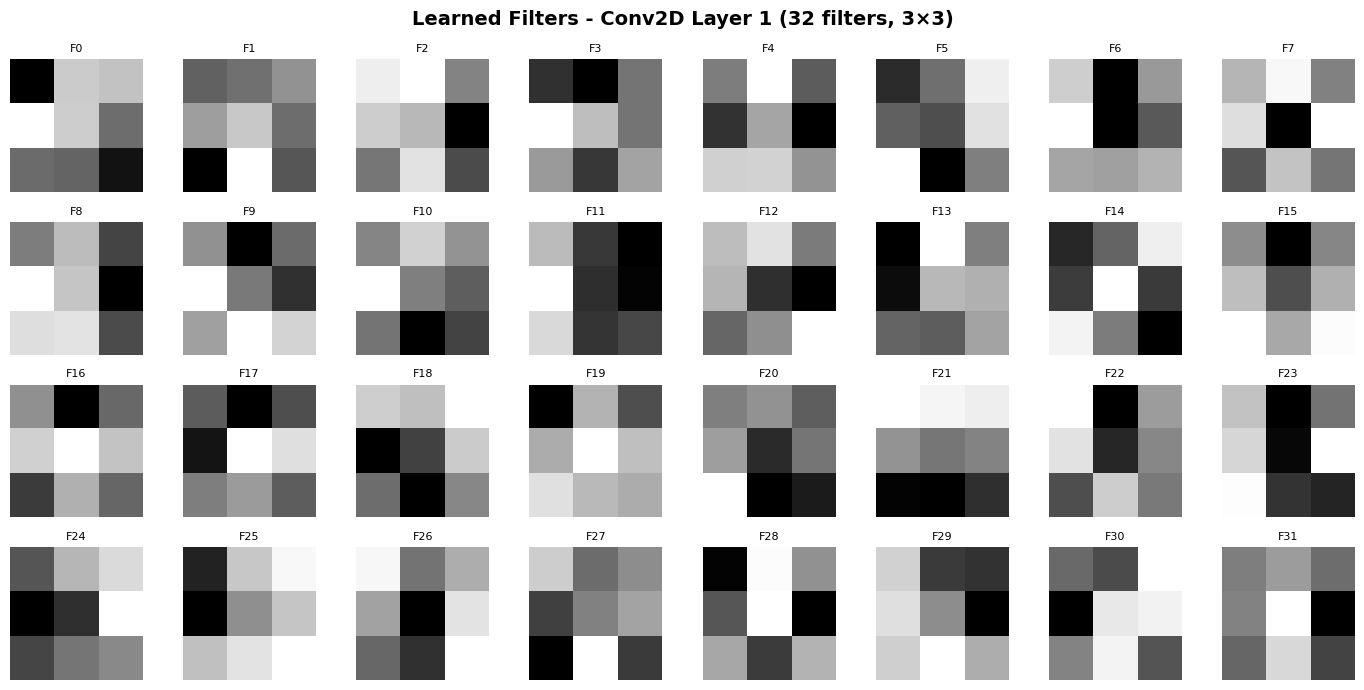

In [ ]:
filters_layer1, biases_layer1 = cnn_model.layers[0].get_weights()

print(f"Layer: {cnn_model.layers[0].name}")
print(f"Filter shape: {filters_layer1.shape}")
print(f"  → {filters_layer1.shape[3]} filters of size {filters_layer1.shape[0]}x{filters_layer1.shape[1]}")

fig, axes = plt.subplots(4, 8, figsize=(14, 7))
fig.suptitle('Learned Filters - Conv2D Layer 1 (32 filters, 3×3)', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    f = filters_layer1[:, :, 0, i] # (3, 3, 1) → squeeze to (3, 3)
    ax.imshow(f, cmap='gray')
    ax.set_title(f'F{i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

## 6.2 Visualize Feature Maps (What the CNN "Sees")

Feature maps are the output of passing an image through a convolutional layer. Each filter produces one feature map.

We will pick one sample image and show:
- **Layer 1 feature maps** (32 maps) → basic features like edges and textures
- **Layer 2 feature maps** (64 maps) → more complex patterns built from layer 1

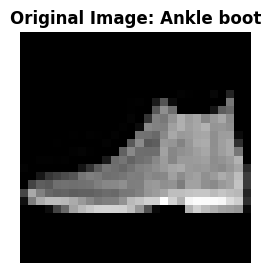

We will pass this 'Ankle boot' image through the CNN and look at the feature maps.


In [ ]:
sample_idx = 0
sample_image = x_test_cnn[sample_idx:sample_idx+1]  # shape (1, 28, 28, 1)
true_label = class_names[y_test[sample_idx]]

plt.figure(figsize=(3, 3))
plt.imshow(sample_image[0, :, :, 0], cmap='gray')
plt.title(f'Original Image: {true_label}', fontweight='bold')
plt.axis('off')
plt.show()

print(f"We will pass this '{true_label}' image through the CNN and look at the feature maps.")

In [ ]:
from tensorflow.keras.models import Model

input_tensor = tf.keras.Input(shape=(28, 28, 1))

x = input_tensor
conv_outputs = []
for layer in cnn_model.layers:
    x = layer(x)
    if isinstance(layer, tf.keras.layers.Conv2D):
        conv_outputs.append(x)

feature_map_model = Model(inputs=input_tensor, outputs=conv_outputs)
feature_maps = feature_map_model.predict(sample_image, verbose=0)

feature_maps_layer1 = feature_maps[0]
feature_maps_layer2 = feature_maps[1]

print(f"Layer 1 feature maps shape: {feature_maps_layer1.shape}  → {feature_maps_layer1.shape[3]} maps of {feature_maps_layer1.shape[1]}x{feature_maps_layer1.shape[2]}")
print(f"Layer 2 feature maps shape: {feature_maps_layer2.shape}  → {feature_maps_layer2.shape[3]} maps of {feature_maps_layer2.shape[1]}x{feature_maps_layer2.shape[2]}")

Layer 1 feature maps shape: (1, 28, 28, 32)  → 32 maps of 28x28
Layer 2 feature maps shape: (1, 14, 14, 64)  → 64 maps of 14x14


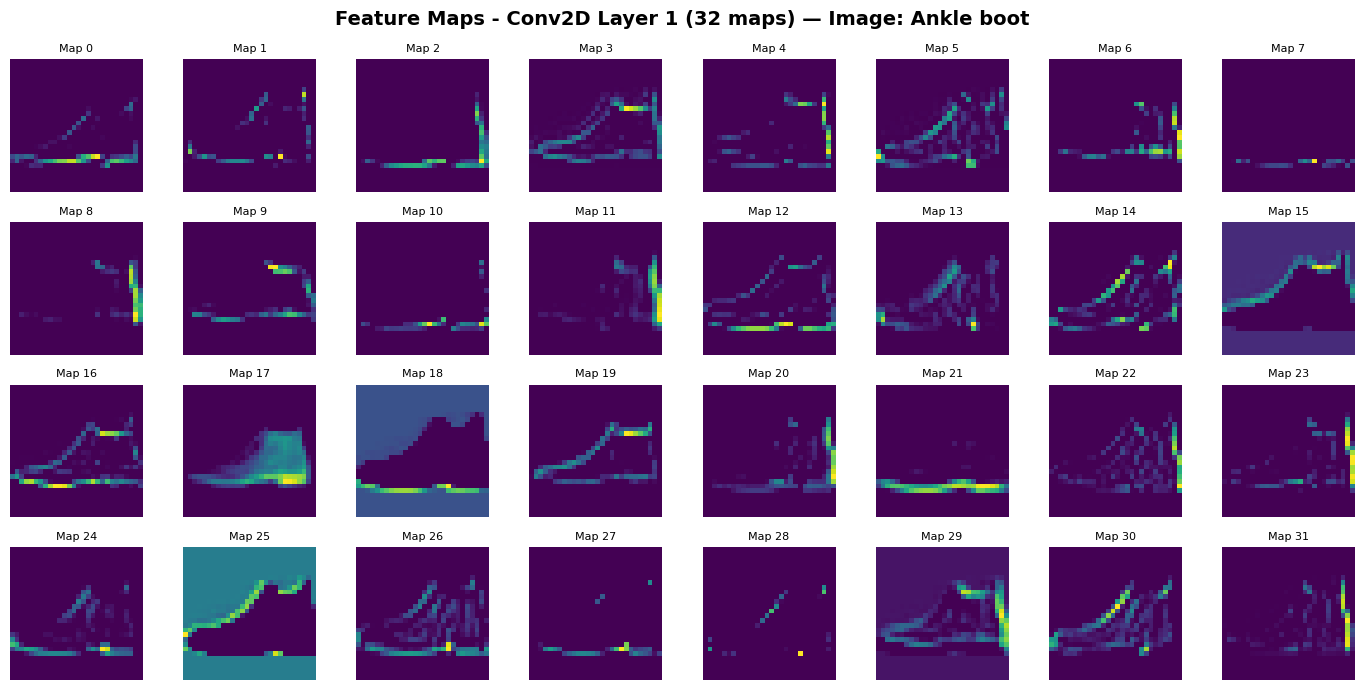

In [ ]:
fig, axes = plt.subplots(4, 8, figsize=(14, 7))
fig.suptitle(f'Feature Maps - Conv2D Layer 1 (32 maps) — Image: {true_label}', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps_layer1[0, :, :, i], cmap='viridis')
    ax.set_title(f'Map {i}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

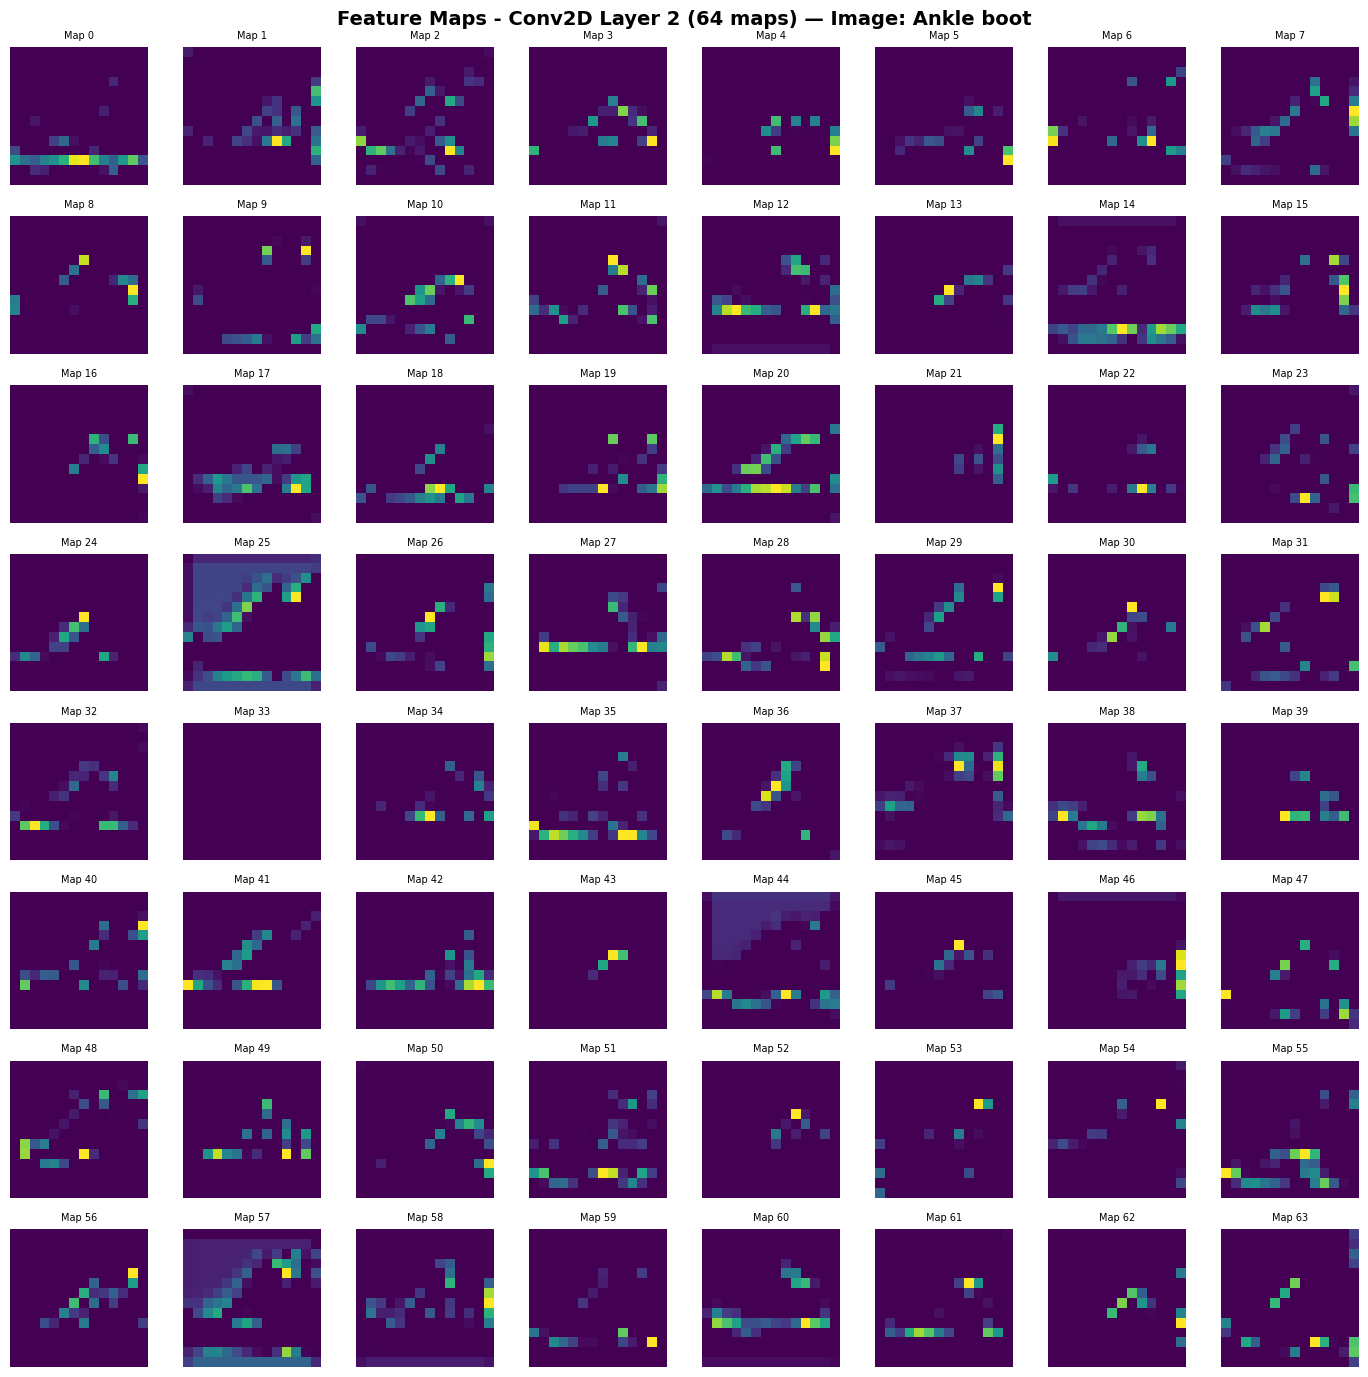

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(14, 14))
fig.suptitle(f'Feature Maps - Conv2D Layer 2 (64 maps) — Image: {true_label}', fontsize=14, fontweight='bold')

for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps_layer2[0, :, :, i], cmap='viridis')
    ax.set_title(f'Map {i}', fontsize=7)
    ax.axis('off')

plt.tight_layout()
plt.show()

### What can we observe?

**Filters (Section 6.1):**
- Each small 3×3 grid shows a different pattern the CNN learned to detect.
- Some filters look like edge detectors (horizontal, vertical, diagonal).
- Others respond to specific textures or intensity changes.

**Feature Maps - Layer 1:**
- Each map highlights different parts of the image.
- Some maps activate strongly on edges (outlines of the clothing).
- Others activate on flat regions or specific textures.

**Feature Maps - Layer 2:**
- The maps are smaller (because of MaxPooling) but more abstract.
- They combine the basic features from Layer 1 into more complex patterns.
- This is how the CNN builds a hierarchical understanding of the image.

---